### Prepare basin GRU (hydrologic unit or GRU) and flowline shapefiles ###

#### If these don't both pre-exist, run this script before all other scripts ####

This script includes:<br>
- Reproject GRU and flowlines shapefiles to a common equal coordinate system. <br>
- Extract basin GRU & flowline shapefiles from large-domain shapefiles.<br> 
- Write basin gruId.txt list for later use.
- Make some directories used for the entire discretization process.

In [1]:
# import libraries
import os, sys
sys.path.append('../')
import functions.geospatial_analysis as ga
import functions.geospatial_plot as gp
import functions.utils as ut
import geopandas as gpd
import rasterio as rio
from rasterio.warp import Resampling
import numpy as np

#### Set up paths, filenames, directories ####

In [2]:
# common paths
control_file    = '../control_Utah.txt'
basin_data_path = ut.read_from_control(control_file, 'basin_data_path')
basin_name      = ut.read_from_control(control_file, 'basin_name')

In [3]:
# make standard directories
if not os.path.exists(basin_data_path):
    os.makedirs(basin_data_path)
plot_path  = os.path.join(basin_data_path, 'plots/')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
gis_path  = os.path.join(basin_data_path, 'gis')
if not os.path.exists(gis_path):
    os.makedirs(gis_path)

In [4]:
# projection system
new_epsg = ut.read_from_control(control_file, 'epsg') 
dest_crs = rio.crs.CRS.from_epsg(new_epsg)

In [5]:
dest_crs

CRS.from_epsg(6933)

In [6]:
# set basin shapefiles
basin_gru_shp           = ut.read_from_control(control_file, 'basin_gru_shp')  
basin_flowlines_shp     = ut.set_filename(control_file, 'basin_flowlines_shp')

# gru fieldname and text file path
gruId_fieldname         = ut.read_from_control(control_file, 'gruId_fieldname')      
basin_gruId_txt         = ut.set_filename(control_file, 'basin_gruId_txt')

# derived filenames
basin_gru_prj_shp       = os.path.join(gis_path,os.path.basename(basin_gru_shp).split('.shp')[0]+'_prj.shp')

if not os.path.exists(basin_gru_shp):
    print('WARNING: basin_gru_shp is not found. If needed, check path/filename before proceeding:', basin_gru_shp)

#### 1. Subset basin GRU shapefile from a larger GRU shapefile (if needed) ####

In [8]:
# if the basin shapefile doesn't exist, it needs to be extracted from another larger GRU shapefile
if not os.path.exists(basin_gru_shp):

    # ---- extract basin GRU shapefile and ID list from a larger full-domain GRU shapefile ---- 

    # read filename and other necessary info
    fulldom_gru_shp   = ut.read_from_control(control_file, 'fulldom_gru_shpfile')
    outlet_gruId      = ut.read_from_control(control_file, 'basin_outlet_gruId')
    # toGRU_fieldname   = ut.read_from_control(control_file, 'toGRU_fieldname')
    data              = gpd.read_file(fulldom_gru_shp)
    
    # check whether two useful columns (gru_field, toGRU_field) are in gru_shp.
    if not gruId_fieldname in data.columns.values:
        exit(gruId_fieldname + ' column does not exist in shapefile.')
    else:
        grus = data[gruId_fieldname].values
    # if not toGRU_fieldname in data.columns.values:
    #     exit(toGRU_fieldname + ' column does not exist in shapefile.')
    # else:
    #     togrus = data[toGRU_fieldname].values
    # extract only the useful columns to save data memory.
    # data = data[[gruId_fieldname, toGRU_fieldname, 'geometry']] 
    data = data[[gruId_fieldname, 'geometry']] 

    # ---- search upstream GRUs ---- 
    # method 1: search upstream grus base on the most downstream gruId
    upstream_grus = [outlet_gruId]           # list of upstream grus. initiate with outlet_gruid
    gru_found     = np.unique(grus[np.where(togrus==outlet_gruId)]) # find all the upstream grus that drain to outlet_gruid.
    upstream_grus.extend(list(gru_found))    # add the found upstream grus of outlet_gruid to upstream_grus list
    round_num     = 0                        # record the round number of searching.

    while len(gru_found) != 0: # terminate searching upstream grus until no one can be found any more.
        round_num = round_num+1
        print("Round %d: %d GRUs found." % (round_num, len(upstream_grus)))

        # search upstream grus
        gru_found_next = []
        for gru_i in gru_found:
            gru_found_next.extend(list(grus[np.where(togrus==gru_i)]))
        gru_found_next = unique(gru_found_next)

        # identify if the found GRUs exist in upstrm_grus
        gru_found = [gru for gru in gru_found_next if not gru in upstream_grus]
        upstream_grus.extend(gru_found)

        # alternate method: manually add upstream_grus when the list of upstream grus is known. 
        #upstream_grus= np.loadtxt('/glade/u/home/andywood/proj/SHARP/wreg/bighorn/prep/lists/gruIds.06279940.txt',dtype=int)

    # ---- save upstream GRU shapefile ---- 
    data[data[gruId_fieldname].isin(upstream_grus)].to_file(basin_gru_shp)

#### 2. Write gruId list for later use ####

In [9]:
# read the basin shapefile and write gruId list
data = gpd.read_file(basin_gru_shp)
if not gruId_fieldname in data.columns.values:
    exit(gruId_fieldname + ' column does not exist in shapefile ' + basin_gru_shp)
else:
    grus = data[gruId_fieldname].values
    
if 'int' in str(grus.dtype):
    np.savetxt(basin_gruId_txt, grus, fmt='%d')
else:
    np.savetxt(basin_gruId_txt, grus, fmt='%s')
print('wrote gruId file for the target basin %s: %s' % (basin_name, basin_gruId_txt))

wrote gruId file for the target basin Utah: /Users/hongliliu/Documents/tmp/utah/gruIds.txt


#### 3. Project basin GRU shapefile 

In [13]:
if not os.path.exists(basin_gru_prj_shp):
    ga.reproject_vector(basin_gru_shp, basin_gru_prj_shp, new_epsg)
elif os.path.exists(basin_gru_prj_shp):
    gdf = gpd.read_file(basin_gru_prj_shp)
    print(gdf.crs)
    if gdf.crs != dest_crs: # Get the projection information
        print('Existing projected shp does not match the desired dest_crs')
        ga.reproject_vector(basin_gru_shp, basin_gru_prj_shp, new_epsg)

print('reprojected basin GRUs:', basin_gru_prj_shp)

EPSG:6933
reprojected basin GRUs: /Users/hongliliu/Documents/tmp/utah/gis/wb-2853886_gru_prj.shp


#### 4. Extract basin flowline shapefile (optional) ####
Do this only if a large-domain flowline shapefile is available.

In [12]:
# -- extract basin flowlines from full-dom flowlines file if it doesn't exist
#    note that the basin flowlines shapefile will be in the common projected coordinates (new_epsg)
#    this step can take a few minutes (wait for 'done')
if os.path.exists(basin_flowlines_shp):   
    os.remove(basin_flowlines_shp)
    
# may need to reproject full-domain flowlines shapefile first
flowlines_shp     = ut.read_from_control(control_file, 'fulldom_flowline_shp')
flowlines_prj_shp = flowlines_shp.split('.shp')[0]+'_prj.shp' 
if not os.path.exists(flowlines_prj_shp):
    ga.reproject_vector(flowlines_shp, flowlines_prj_shp, new_epsg)
    print('reprojected full domain streams:', flowlines_prj_shp)
elif os.path.exists(flowlines_prj_shp):
    gdf = gpd.read_file(flowlines_prj_shp)
    if gdf.crs != new_epsg:
        ga.reproject_vector(flowlines_shp, flowlines_prj_shp, new_epsg)
    print('reprojected full domain streams:', flowlines_prj_shp)

# read stream and boundary files (projected)
flowlines_gpd = gpd.read_file(flowlines_prj_shp)
basin_gru_gpd = gpd.read_file(basin_gru_prj_shp)
print('read reprojected shapefiles for clipping flowlines')    

# create basin outer boundary shapefile 
tmp_gpd                  = basin_gru_gpd[['geometry']]
basin_gru_gpd['tmp_col'] = 0         # create null column for dissolve
basin_boundary_gpd       = basin_gru_gpd.dissolve(by='tmp_col')
basin_boundary_prj_shp   = basin_gru_prj_shp.split('.shp')[0]+'_boundary.shp'
basin_boundary_gpd.to_file(basin_boundary_prj_shp)
print('wrote basin boundary shapefile to use in stream clipping:', basin_boundary_prj_shp) 

# clip full-dom reprojected flowlines with basin boundary     
basin_boundary = gpd.read_file(basin_boundary_prj_shp)
flowlines = gpd.read_file(flowlines_prj_shp)
clipped_flowlines = gpd.clip(flowlines, basin_boundary)
clipped_flowlines.to_file(basin_flowlines_shp, driver='ESRI Shapefile')

print('wrote basin-clipped stream shapefile:', basin_flowlines_shp)
print('done')

wrote basin-clipped stream shapefile: /Users/hongliliu/Documents/tmp/utah/flowlines_prj.shp
done


#### 5. Plot basin GRU and streamline (optional)

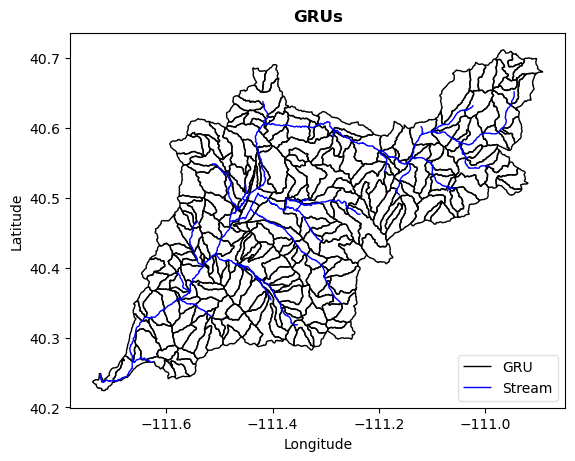

In [7]:
wgs_epsg = 4326
title = 'GRUs'
ofile = os.path.join(plot_path, '1_gru_streamline.png')
gp.plot_gru_bound(basin_gru_prj_shp,basin_flowlines_shp,wgs_epsg,title,ofile)